In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from abtem import *

# Effect of temperature with frozen phonons

The atoms in any real material at a particular instance of time are not exactly located at their symmetrical lattice points due to thermal and zero-point vibrations. The frozen phonon approximation is a simple if somewhat brute-force approach to numerically simulate the effects of thermal vibrations in the specimen. In the Frozen phonon approximation, the simulated image or diffraction pattern is the intensity averaged over several different configurations of atoms with different random offsets. This type of scattering may be referred to as thermal diffuse scattering or simply TDS.

We will simulate strontium titanate [100] with TDS. In order to observe visible Kikuchi lines, the sample needs a certain thickness, hence we repeat the unit cell 40 times along the z-direction.

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

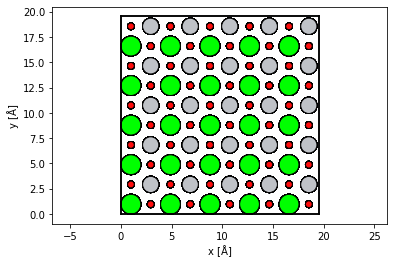

In [2]:
atoms = read('data/srtio3_100.cif')

atoms *= (5, 5, 80)
atoms.center()

show_atoms(atoms)

The `FrozenPhonon` class generates offsets from a Gaussian distribution (equivalent to the Einstein model of the density of states for phonons) using a random number generator with a given seed. The standard deviation of the Gaussian distribution is provided for each element as a dictionary.

In [3]:
frozen_phonons = FrozenPhonons(atoms, 12, {'Sr' : .1, 'Ti' : .1, 'O' : .1}, seed=1)

We can get out one of frozen phonon configurations by iterating the `FrozenPhonons` class.

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

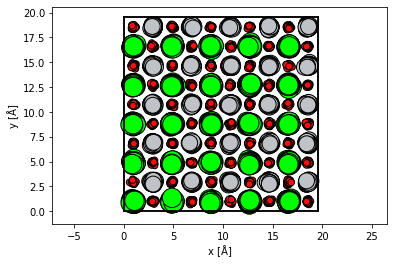

In [4]:
atoms_conf = next(iter(frozen_phonons))

show_atoms(atoms_conf)

The `FrozenPhonons` class is given as argument instead of the atoms object. The potential now represents an ensemble of potentials with slightly displaced atomic configurations. We use the `infinite` projection scheme to speed up the calculation.

In [5]:
potential = Potential(frozen_phonons, gpts=512, slice_thickness=2, projection='infinite', parametrization='kirkland')

We can run a multislice simulation for an incoming plane wave of 300 keV energy just as without the frozen phonons, with one distinction.

In [6]:
from abtem.waves import PlaneWave

wave = PlaneWave(energy=300e3)

exit_waves = wave.multislice(potential)

The output is a stack of 12 exit waves, one for each potential in the frozen phonon ensemble.

In [7]:
exit_waves.array.shape

(12, 512, 512)

We show the intensity of the one of the exit waves and the average intensity of the thermal ensemble.

Text(0.5, 1.0, 'Thermal ensemble')

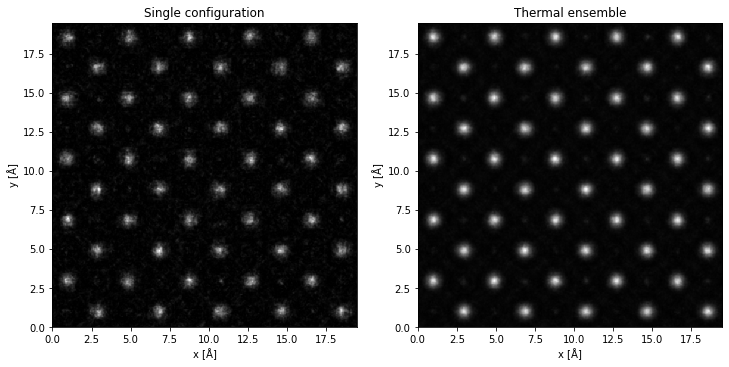

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

exit_waves[0].show(ax = ax1)
ax1.set_title('Single configuration')
exit_waves.intensity().mean(0).show(ax = ax2)
ax2.set_title('Thermal ensemble')

We can apply a contrast transfer to the stack of exit waves, then take the mean of the intensity to get a more realistic image.

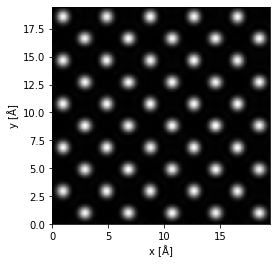

In [9]:
image_waves = exit_waves.apply_ctf(defocus=-45.47, Cs = -7e-6 * 1e10, focal_spread=50)

image_waves.intensity().mean(0).show();

We take the mean of the diffraction patterns to get the final diffraction pattern.

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x20696ad0490>)

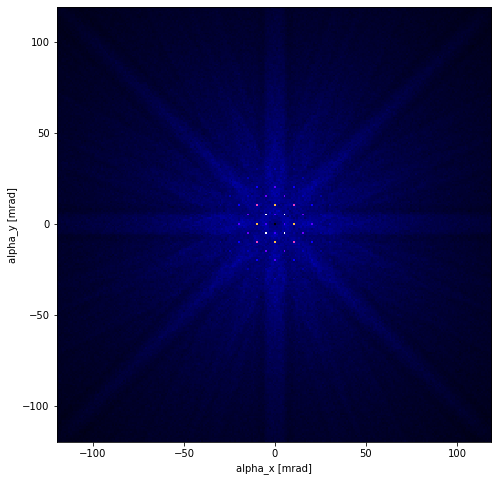

In [10]:
patterns = exit_waves.diffraction_pattern('valid', block_zeroth_order=True)

fig, ax = plt.subplots(1,1,figsize=(8,8))

patterns.mean(0).show(ax=ax, cmap='gnuplot2', power=.25)

## STEM with TDS

Simulating STEM with TDS is not much different from what we have shown so far. We will simulate the same graphene image as we did earlier, now including TDS. We start by importing the necessary objects.

In [11]:
atoms = read('data/orthogonal_graphene.cif')

probe = Probe(energy=80e3, semiangle_cutoff=30, focal_spread=60, defocus=50)

linescan = LineScan(start=[2 * np.sqrt(3) * 1.42, 0], end=[2 * np.sqrt(3) * 1.42, 3 * 1.42], gpts=40, endpoint=False)

haadf = AnnularDetector(inner=90, outer=200)

We set up the TDS potential as above.

In [12]:
frozen_phonons = FrozenPhonons(atoms, 32, {'C' : .1}, seed=10)

potential = Potential(frozen_phonons, sampling=.02)

Then we run the simulation.

In [13]:
tds_measurement = probe.scan(linescan, haadf, potential, pbar=True)

We compare the simulation with TDS, to the one without. We see that TDS tends to increase high-angle scattering. In this case, the difference is quite modset, but it would be much more pronounced for a thicker sample. We also see that the line with TDS is assymetric, and thus clearly we would need to increase the number of frozen phonon configurations.

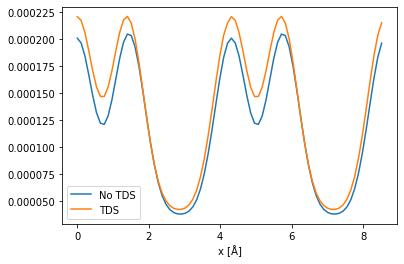

In [14]:
no_tds_measurement = Measurement.read('data/linescan.hdf5')

fig, ax = plt.subplots(1, 1)

ax, line = no_tds_measurement.tile((2,)).show(ax=ax)
line.set_label('No TDS')

ax, line = tds_measurement.tile((2,)).show(ax=ax)
line.set_label('TDS')

ax.legend()

## Explicit MD calculation of thermal displacements

Since abTEM interfaces directly with ASE (and optionally GPAW), it is easy to use explicit molecular dynamics (MD) simulations to model the thermal vibrations of the atoms, and use the MD trajectory for the description of thermal diffuse scattering.

For this walkthrough, we draw on the ASE tutorial on MD (https://wiki.fysik.dtu.dk/ase/tutorials/md/md.html). This uses a fast but approximate EMT potential to describe a Cu nanoparticle, but any atomistic potential or calculator can be used. In a high-performance environment we could use a GPAW calculator to perform *ab initio* molecular dynamics.

In [15]:
"""Demonstrates molecular dynamics for an isolated particle."""
from ase.cluster.cubic import FaceCenteredCubic
from ase.optimize import QuasiNewton
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase import units

from ase.calculators.emt import EMT

size = 2

# Set up a nanoparticle
atoms = FaceCenteredCubic('Cu',
                          surfaces=[[1, 0, 0], [1, 1, 0], [1, 1, 1]],
                          layers=(size, size, size),
                          vacuum=4)

# Describe the interatomic interactions with the Effective Medium Theory
atoms.calc = EMT()

# Do a quick relaxation of the cluster
qn = QuasiNewton(atoms)
qn.run(0.001, 10)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, 300 * units.kB)
Stationary(atoms)  # zero linear momentum
ZeroRotation(atoms)  # zero angular momentum

# We want to run MD using the VelocityVerlet algorithm and save the trajectory file.
dyn = VelocityVerlet(atoms, 5 * units.fs, trajectory='data/Cu_fcc_md.traj')

# Now run the dynamics for 500 timesteps.
dyn.run(500)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 11:08:02       13.634756*       0.9186
BFGSLineSearch:    1[  1] 11:08:02       13.191866*       0.3354
BFGSLineSearch:    2[  2] 11:08:02       13.145727*       0.0532
BFGSLineSearch:    3[  3] 11:08:02       13.143624*       0.0113
BFGSLineSearch:    4[  4] 11:08:02       13.143516*       0.0010


True

We can load the trajectory and visualize the dynamics outside Jupyter using ASE.

In [16]:
from ase.io.trajectory import Trajectory
from ase.visualize import view

traj = Trajectory('data/Cu_fcc_md.traj', 'r')

#view(traj)

C:\Users\jacob\anaconda3\envs\abtem\lib\site-packages\ase\io\jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


Alternatively, we can show individual snapshots (here at timesteps 100, 300 and 500).

C:\Users\jacob\anaconda3\envs\abtem\lib\site-packages\ase\io\jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)
C:\Users\jacob\anaconda3\envs\abtem\lib\site-packages\ase\io\jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

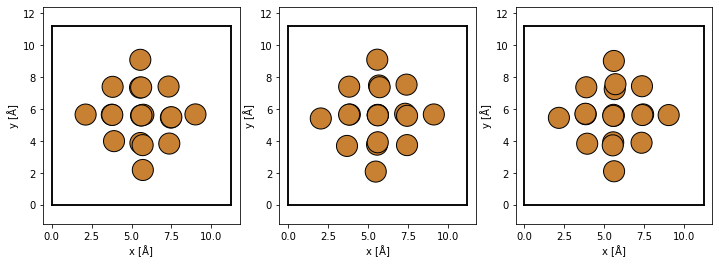

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

show_atoms(traj[150], ax = ax1)
show_atoms(traj[300], ax = ax2)
show_atoms(traj[450], ax = ax3)

We then set abTEM to use the potential for every 10th atomic configuration in the trajectory.

In [18]:
from abtem.temperature import MDFrozenPhonons

configs = traj[::10]

md_phonons = MDFrozenPhonons(configs)

potential = Potential(md_phonons, sampling=.04, slice_thickness=2)

C:\Users\jacob\anaconda3\envs\abtem\lib\site-packages\ase\io\jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


We can then run a TEM multislice simulation exactly as in the example above.

In [19]:
from abtem.waves import PlaneWave

wave = PlaneWave(energy=300e3)

exit_waves = wave.multislice(potential)

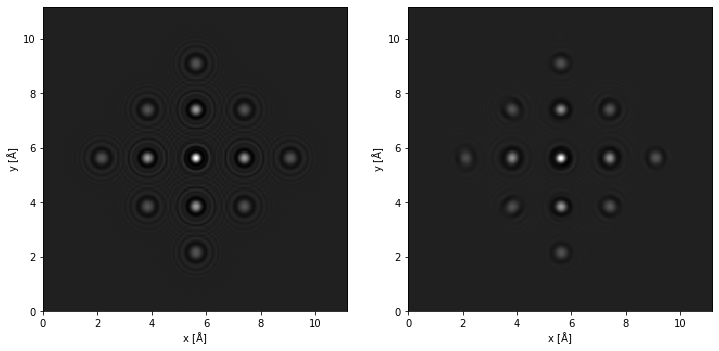

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

exit_waves[0].show(ax = ax1)
exit_waves.intensity().mean(0).show(ax = ax2);